In [1]:
# Reload modules whenever underlying code changes
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from sgm.dependencies import *


Bad key savefig.frameon in file /home/mgaltier200/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/mgaltier200/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/mgaltier200/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

In [3]:
from sgm.envs import env_load_fn
from sgm.agent import UvfAgent
from sgm.trainer import train_eval
from sgm.envs import *
from scipy.spatial import distance
from sgm.evaluation import cleanup_and_eval
from sgm.planner import SoRBSearchPolicy
    
def generalized_difficulty(resize_factor):
    tf.reset_default_graph()

    # If you change the environment parameters below, make sure to run
    # tf.reset_default_graph() in the cell above before training.
    max_episode_steps = 20
    env_name = 'FourRooms'  # Choose one of the environments shown above. 
    resize_factor = resize_factor  # Inflate the environment to increase the difficulty.
    thin = True # If True, resize by expanding open space, not walls, to make walls thin
    desc_name = "thinned_" + env_name.lower() if thin else env_name.lower()

    base_dir = os.path.join(os.getcwd(), os.pardir, "agents")
    model_dir = os.path.join(base_dir, desc_name)

    tf_env = env_load_fn(env_name, max_episode_steps,
                         resize_factor=resize_factor,
                         terminate_on_timeout=False,
                         thin=thin)
    eval_tf_env = env_load_fn(env_name, max_episode_steps,
                              resize_factor=resize_factor,
                              terminate_on_timeout=True,
                              thin=thin)

    agent = UvfAgent(
        tf_env.time_step_spec(),
        tf_env.action_spec(),
        max_episode_steps=max_episode_steps,
        use_distributional_rl=True,
        ensemble_size=3)



    train_eval(agent,
              tf_env,
              eval_tf_env,
              initial_collect_steps=1000,
              eval_interval=1000,
              num_eval_episodes=10,
              num_iterations=30000,
              save_model_dir=model_dir,
              experiment_name=f"{resize_factor}_{env_name}_coordinate_{max_episode_steps}steps")

    filename = str(resize_factor)+"_FourRooms_coordinate_20steps-Dec-05-2019-12-58-28-PM/ckpt/"
    checkpoint_file = os.path.join(model_dir, filename)

    ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=agent)
    manager = tf.train.CheckpointManager(ckpt, checkpoint_file, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)

    #@title Fill the replay buffer with random data  {vertical-output: true, run: "auto" }
    replay_buffer_size = 2000 #@param {min:100, max: 1000, step: 100, type:"slider"}

    eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
        prob_constraint=0.0,
        min_dist=0,
        max_dist=np.inf)
    rb_vec = []
    for it in range(replay_buffer_size):
        ts = eval_tf_env.reset()
        rb_vec.append(ts.observation['observation'].numpy()[0])
    rb_vec = np.array(rb_vec)


    plt.figure(figsize=(6, 6))
    plt.scatter(*rb_vec.T)
    plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
    plt.show()

    pdist = agent._get_pairwise_dist(rb_vec, aggregate=None).numpy()

    plt.figure(figsize=(6, 3))
    plt.hist(pdist.flatten(), bins=range(20))
    plt.xlabel('predicted distance')
    plt.ylabel('number of (s, g) pairs')
    plt.show()

    euclidean_dists = distance.pdist(rb_vec)

    plt.figure(figsize=(6, 3))
    plt.hist(euclidean_dists.flatten())
    plt.xlabel('Euclidean distance')
    plt.ylabel('number of pairwise distances')
    plt.show()

    search_policy_type = "SoRB"
    agent.initialize_search(rb_vec, max_search_steps=6)
    search_policy = SoRBSearchPolicy(agent, pdist, rb_vec)


    logdir = os.path.join(os.getcwd(), os.pardir, "logs")
    eval_difficulty = 0.95
    k_nearest = 5
    eval_trials = 20
    total_cleanup_steps = 50000
    eval_period = 5000

    logfolder = cleanup_and_eval(search_policy,
                                 search_policy_type,
                                 desc_name,
                                 eval_tf_env,
                                 logdir,
                                 eval_difficulty=eval_difficulty,
                                 k_nearest=k_nearest,
                                 eval_trials=eval_trials,
                                 total_cleanup_steps=total_cleanup_steps,
                                 eval_period=eval_period)

/home/mgaltier200/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



INFO:tensorflow:random_seed = 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Saving checkpoints to directory /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt
INFO:tensorflow:Creating tensorboard summary writer with directory /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



  3%|▎         | 998/30000 [00:22<08:48, 54.84it/s] 

Saved checkpoint for step 1000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-1
INFO:tensorflow:step = 1000, loss = 1.922770
INFO:tensorflow:47.350 steps/sec
INFO:tensorflow:step = 1000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -16.50
INFO:tensorflow:		 predicted_dist = 17.3 (0.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 16.9 (0.7)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.1 (0.6)
INFO:tensorflow:	 eval_time = 3.91


  7%|▋         | 1998/30000 [00:46<09:02, 51.65it/s]  

Saved checkpoint for step 2000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-2
INFO:tensorflow:step = 2000, loss = 0.735156
INFO:tensorflow:56.448 steps/sec
INFO:tensorflow:step = 2000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.40
INFO:tensorflow:		 predicted_dist = 18.4 (0.7)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -17.50
INFO:tensorflow:		 predicted_dist = 18.7 (0.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 19.0 (0.4)
INFO:tensorflow:	 eval_time = 3.83


 10%|▉         | 2999/30000 [01:09<09:48, 45.92it/s]  

Saved checkpoint for step 3000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-3
INFO:tensorflow:step = 3000, loss = 0.679223
INFO:tensorflow:55.902 steps/sec
INFO:tensorflow:step = 3000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -16.30
INFO:tensorflow:		 predicted_dist = 18.7 (0.3)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 18.6 (0.4)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 18.6 (0.5)
INFO:tensorflow:	 eval_time = 3.61


 13%|█▎        | 3994/30000 [01:32<08:30, 50.93it/s]  

Saved checkpoint for step 4000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-4
INFO:tensorflow:step = 4000, loss = 0.805907
INFO:tensorflow:56.206 steps/sec
INFO:tensorflow:step = 4000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -15.10
INFO:tensorflow:		 predicted_dist = 17.2 (1.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.8 (0.9)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 18.5 (0.5)
INFO:tensorflow:	 eval_time = 3.43


 17%|█▋        | 4995/30000 [01:55<08:36, 48.37it/s]  

Saved checkpoint for step 5000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-5
INFO:tensorflow:step = 5000, loss = 1.085215
INFO:tensorflow:56.182 steps/sec
INFO:tensorflow:step = 5000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -17.50
INFO:tensorflow:		 predicted_dist = 18.1 (0.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 18.0 (0.7)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 18.5 (0.7)
INFO:tensorflow:	 eval_time = 3.48


 20%|█▉        | 5996/30000 [02:17<07:34, 52.87it/s]  

Saved checkpoint for step 6000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-6
INFO:tensorflow:step = 6000, loss = 0.894707
INFO:tensorflow:58.020 steps/sec
INFO:tensorflow:step = 6000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -18.10
INFO:tensorflow:		 predicted_dist = 18.0 (0.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.9 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.8 (1.1)
INFO:tensorflow:	 eval_time = 3.53


 23%|██▎       | 6994/30000 [02:39<06:50, 56.09it/s]  

Saved checkpoint for step 7000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-7
INFO:tensorflow:step = 7000, loss = 1.004900
INFO:tensorflow:61.349 steps/sec
INFO:tensorflow:step = 7000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.70
INFO:tensorflow:		 predicted_dist = 15.8 (1.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.60
INFO:tensorflow:		 predicted_dist = 17.3 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.90
INFO:tensorflow:		 predicted_dist = 17.2 (1.1)
INFO:tensorflow:	 eval_time = 2.80


 27%|██▋       | 7995/30000 [03:00<07:02, 52.08it/s]

Saved checkpoint for step 8000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-8
INFO:tensorflow:step = 8000, loss = 1.322597
INFO:tensorflow:57.792 steps/sec
INFO:tensorflow:step = 8000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -15.70
INFO:tensorflow:		 predicted_dist = 16.0 (0.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.60
INFO:tensorflow:		 predicted_dist = 16.5 (0.7)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 16.9 (0.4)
INFO:tensorflow:	 eval_time = 3.20


 30%|██▉       | 8997/30000 [03:23<06:38, 52.68it/s]  

Saved checkpoint for step 9000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-9
INFO:tensorflow:step = 9000, loss = 1.227003
INFO:tensorflow:56.740 steps/sec
INFO:tensorflow:step = 9000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -13.10
INFO:tensorflow:		 predicted_dist = 16.8 (1.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.50
INFO:tensorflow:		 predicted_dist = 17.4 (0.7)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.2 (0.5)
INFO:tensorflow:	 eval_time = 2.87


 33%|███▎      | 9995/30000 [03:44<06:15, 53.25it/s]

Saved checkpoint for step 10000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-10
INFO:tensorflow:step = 10000, loss = 0.959760
INFO:tensorflow:59.795 steps/sec
INFO:tensorflow:step = 10000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -18.10
INFO:tensorflow:		 predicted_dist = 17.8 (1.3)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.9 (0.9)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 18.3 (0.7)
INFO:tensorflow:	 eval_time = 3.36


 37%|███▋      | 10999/30000 [04:07<06:55, 45.74it/s]  

Saved checkpoint for step 11000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-11
INFO:tensorflow:step = 11000, loss = 0.949721
INFO:tensorflow:56.492 steps/sec
INFO:tensorflow:step = 11000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.50
INFO:tensorflow:		 predicted_dist = 16.5 (1.7)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.6 (1.1)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.00
INFO:tensorflow:		 predicted_dist = 17.8 (1.2)
INFO:tensorflow:	 eval_time = 3.33


 40%|███▉      | 11995/30000 [04:29<05:38, 53.26it/s]  

Saved checkpoint for step 12000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-12
INFO:tensorflow:step = 12000, loss = 1.040958
INFO:tensorflow:56.393 steps/sec
INFO:tensorflow:step = 12000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -18.10
INFO:tensorflow:		 predicted_dist = 17.1 (0.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.80
INFO:tensorflow:		 predicted_dist = 17.8 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.10
INFO:tensorflow:		 predicted_dist = 18.3 (0.7)
INFO:tensorflow:	 eval_time = 3.24


 43%|████▎     | 12998/30000 [04:51<04:46, 59.38it/s]

Saved checkpoint for step 13000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-13
INFO:tensorflow:step = 13000, loss = 1.261048
INFO:tensorflow:58.880 steps/sec
INFO:tensorflow:step = 13000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -13.30
INFO:tensorflow:		 predicted_dist = 16.3 (1.4)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -15.60
INFO:tensorflow:		 predicted_dist = 16.5 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.2 (1.1)
INFO:tensorflow:	 eval_time = 3.43


 47%|████▋     | 13997/30000 [05:12<04:33, 58.57it/s]

Saved checkpoint for step 14000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-14
INFO:tensorflow:step = 14000, loss = 1.955256
INFO:tensorflow:62.651 steps/sec
INFO:tensorflow:step = 14000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -18.20
INFO:tensorflow:		 predicted_dist = 15.8 (2.3)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.40
INFO:tensorflow:		 predicted_dist = 16.8 (1.2)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.3 (1.0)
INFO:tensorflow:	 eval_time = 3.14


 50%|████▉     | 14999/30000 [05:32<04:46, 52.40it/s]

Saved checkpoint for step 15000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-15
INFO:tensorflow:step = 15000, loss = 1.247255
INFO:tensorflow:63.771 steps/sec
INFO:tensorflow:step = 15000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -13.00
INFO:tensorflow:		 predicted_dist = 15.7 (1.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.5 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.9 (0.8)
INFO:tensorflow:	 eval_time = 2.78


 53%|█████▎    | 15994/30000 [05:51<03:41, 63.14it/s]

Saved checkpoint for step 16000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-16
INFO:tensorflow:step = 16000, loss = 1.371554
INFO:tensorflow:68.627 steps/sec
INFO:tensorflow:step = 16000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -13.90
INFO:tensorflow:		 predicted_dist = 15.0 (1.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.10
INFO:tensorflow:		 predicted_dist = 16.5 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.6 (0.5)
INFO:tensorflow:	 eval_time = 2.79


 57%|█████▋    | 16998/30000 [06:09<03:22, 64.08it/s]

Saved checkpoint for step 17000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-17
INFO:tensorflow:step = 17000, loss = 1.649153
INFO:tensorflow:68.103 steps/sec
INFO:tensorflow:step = 17000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -10.00
INFO:tensorflow:		 predicted_dist = 13.0 (3.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -19.30
INFO:tensorflow:		 predicted_dist = 16.6 (0.8)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.80
INFO:tensorflow:		 predicted_dist = 17.5 (1.0)
INFO:tensorflow:	 eval_time = 2.83


 60%|█████▉    | 17999/30000 [06:28<03:35, 55.63it/s]

Saved checkpoint for step 18000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-18
INFO:tensorflow:step = 18000, loss = 1.551343
INFO:tensorflow:69.831 steps/sec
INFO:tensorflow:step = 18000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -18.50
INFO:tensorflow:		 predicted_dist = 16.3 (0.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.80
INFO:tensorflow:		 predicted_dist = 16.6 (1.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.40
INFO:tensorflow:		 predicted_dist = 17.6 (0.7)
INFO:tensorflow:	 eval_time = 2.81


 63%|██████▎   | 18994/30000 [06:46<02:44, 67.11it/s]

Saved checkpoint for step 19000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-19
INFO:tensorflow:step = 19000, loss = 1.487956
INFO:tensorflow:69.035 steps/sec
INFO:tensorflow:step = 19000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -18.30
INFO:tensorflow:		 predicted_dist = 15.4 (1.6)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.80
INFO:tensorflow:		 predicted_dist = 17.4 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.7 (1.0)
INFO:tensorflow:	 eval_time = 3.05


 67%|██████▋   | 19993/30000 [07:04<02:23, 69.75it/s]

Saved checkpoint for step 20000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-20
INFO:tensorflow:step = 20000, loss = 1.252560
INFO:tensorflow:71.841 steps/sec
INFO:tensorflow:step = 20000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.90
INFO:tensorflow:		 predicted_dist = 15.7 (1.4)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 16.7 (1.1)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.40
INFO:tensorflow:		 predicted_dist = 17.5 (0.7)
INFO:tensorflow:	 eval_time = 2.80


 70%|██████▉   | 20994/30000 [07:22<02:18, 65.13it/s]

Saved checkpoint for step 21000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-21
INFO:tensorflow:step = 21000, loss = 1.526368
INFO:tensorflow:73.028 steps/sec
INFO:tensorflow:step = 21000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.70
INFO:tensorflow:		 predicted_dist = 15.7 (1.9)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -17.50
INFO:tensorflow:		 predicted_dist = 17.2 (0.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 18.0 (0.3)
INFO:tensorflow:	 eval_time = 2.98


 73%|███████▎  | 21999/30000 [07:41<02:13, 60.08it/s]

Saved checkpoint for step 22000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-22
INFO:tensorflow:step = 22000, loss = 1.481772
INFO:tensorflow:68.971 steps/sec
INFO:tensorflow:step = 22000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -15.70
INFO:tensorflow:		 predicted_dist = 13.9 (2.9)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -19.90
INFO:tensorflow:		 predicted_dist = 16.1 (1.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.2 (1.6)
INFO:tensorflow:	 eval_time = 2.85


 77%|███████▋  | 22996/30000 [07:59<01:45, 66.67it/s]

Saved checkpoint for step 23000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-23
INFO:tensorflow:step = 23000, loss = 1.719709
INFO:tensorflow:67.968 steps/sec
INFO:tensorflow:step = 23000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -13.00
INFO:tensorflow:		 predicted_dist = 15.2 (1.3)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -14.70
INFO:tensorflow:		 predicted_dist = 16.5 (1.1)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.90
INFO:tensorflow:		 predicted_dist = 17.7 (0.6)
INFO:tensorflow:	 eval_time = 2.87


 80%|███████▉  | 23995/30000 [08:17<01:32, 64.87it/s]

Saved checkpoint for step 24000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-24
INFO:tensorflow:step = 24000, loss = 2.003470
INFO:tensorflow:70.446 steps/sec
INFO:tensorflow:step = 24000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -18.90
INFO:tensorflow:		 predicted_dist = 14.5 (2.1)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 16.4 (1.0)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.50
INFO:tensorflow:		 predicted_dist = 17.7 (0.5)
INFO:tensorflow:	 eval_time = 3.03


 83%|████████▎ | 24998/30000 [08:36<01:18, 63.81it/s]

Saved checkpoint for step 25000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-25
INFO:tensorflow:step = 25000, loss = 1.825873
INFO:tensorflow:68.618 steps/sec
INFO:tensorflow:step = 25000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -14.50
INFO:tensorflow:		 predicted_dist = 12.7 (3.7)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -17.20
INFO:tensorflow:		 predicted_dist = 15.7 (2.4)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.50
INFO:tensorflow:		 predicted_dist = 17.8 (0.7)
INFO:tensorflow:	 eval_time = 2.86


 87%|████████▋ | 25998/30000 [08:55<01:02, 64.40it/s]

Saved checkpoint for step 26000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-26
INFO:tensorflow:step = 26000, loss = 1.454148
INFO:tensorflow:70.183 steps/sec
INFO:tensorflow:step = 26000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -18.10
INFO:tensorflow:		 predicted_dist = 14.3 (2.5)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -18.50
INFO:tensorflow:		 predicted_dist = 16.1 (2.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.8 (0.7)
INFO:tensorflow:	 eval_time = 3.07


 90%|████████▉ | 26993/30000 [09:12<00:40, 74.10it/s]

Saved checkpoint for step 27000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-27
INFO:tensorflow:step = 27000, loss = 2.177581
INFO:tensorflow:73.493 steps/sec
INFO:tensorflow:step = 27000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -17.40
INFO:tensorflow:		 predicted_dist = 16.5 (1.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -17.30
INFO:tensorflow:		 predicted_dist = 16.4 (1.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.10
INFO:tensorflow:		 predicted_dist = 17.9 (0.9)
INFO:tensorflow:	 eval_time = 2.92


 93%|█████████▎| 27993/30000 [09:30<00:28, 69.52it/s]

Saved checkpoint for step 28000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-28
INFO:tensorflow:step = 28000, loss = 1.879373
INFO:tensorflow:73.253 steps/sec
INFO:tensorflow:step = 28000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -11.70
INFO:tensorflow:		 predicted_dist = 13.9 (1.7)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -17.20
INFO:tensorflow:		 predicted_dist = 16.6 (1.5)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -19.90
INFO:tensorflow:		 predicted_dist = 17.5 (0.9)
INFO:tensorflow:	 eval_time = 2.12


 97%|█████████▋| 28998/30000 [09:47<00:14, 69.67it/s]

Saved checkpoint for step 29000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-29
INFO:tensorflow:step = 29000, loss = 1.917538
INFO:tensorflow:73.142 steps/sec
INFO:tensorflow:step = 29000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -18.10
INFO:tensorflow:		 predicted_dist = 12.5 (3.1)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -20.00
INFO:tensorflow:		 predicted_dist = 16.1 (0.9)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -20.00
INFO:tensorflow:		 predicted_dist = 17.5 (0.8)
INFO:tensorflow:	 eval_time = 2.76


100%|█████████▉| 29993/30000 [10:04<00:00, 70.83it/s]

Saved checkpoint for step 30000: /home/mgaltier200/sgm/notebooks/../agents/thinned_fourrooms/9_FourRooms_coordinate_20steps-May-17-2021-09-19-58-PM/ckpt/ckpt-30
INFO:tensorflow:step = 30000, loss = 2.012410
INFO:tensorflow:73.437 steps/sec
INFO:tensorflow:step = 30000
INFO:tensorflow:	 set goal dist = 2
INFO:tensorflow:		 AverageReturn (eval distance=2.000000) -13.50
INFO:tensorflow:		 predicted_dist = 13.5 (3.8)
INFO:tensorflow:	 set goal dist = 5
INFO:tensorflow:		 AverageReturn (eval distance=5.000000) -14.50
INFO:tensorflow:		 predicted_dist = 16.2 (1.3)
INFO:tensorflow:	 set goal dist = 10
INFO:tensorflow:		 AverageReturn (eval distance=10.000000) -18.70
INFO:tensorflow:		 predicted_dist = 17.8 (0.5)
INFO:tensorflow:	 eval_time = 2.33


100%|██████████| 30000/30000 [10:07<00:00, 49.41it/s]


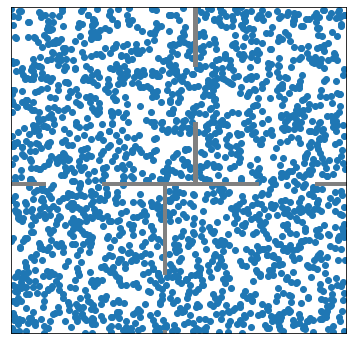

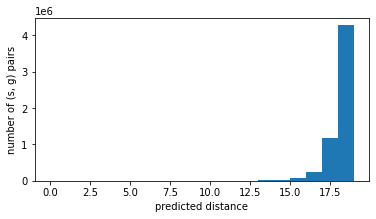

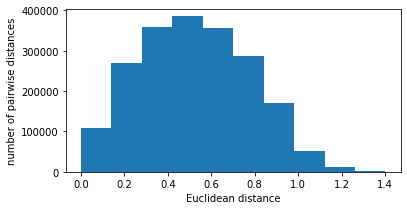

SoRB has initial success rate 0.00
Evaluated initial SoRB success rate in 408.80 seconds
After filtering and 0 cleanup steps, SoRB has success rate 0.00


In [ ]:
generalized_difficulty(9)